In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from numpy.linalg import svd,eig
from cv2 import Stitcher
from scipy.signal import convolve2d
from scipy.interpolate import  Rbf,griddata 

In [ ]:
%%capture
! wget -O img1.jpg "https://drive.google.com/uc?export=download&id=1omMydL6ADxq_vW5gl_1EFhdzT9kaMhUt"
! wget -O img2.jpg "https://drive.google.com/uc?export=download&id=12lxB1ArAlwGn97XgBgt-SFyjE7udMGvf"

# Visualize Input Images

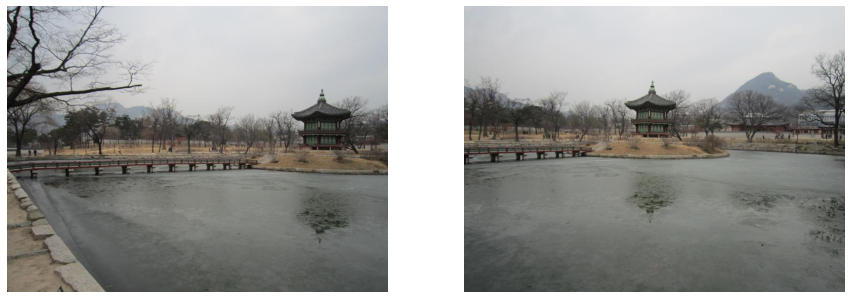

In [ ]:
img1 = plt.imread('img1.jpg')
img2 = plt.imread('img2.jpg')

def plot_imgs(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(15, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(img1)
  ax[1].imshow(img2)

plot_imgs(img1, img2)

# Compute SURF/ SIFT/ ORB Features and Match Keypoints

In [ ]:
def get_features(img):
  '''
    Compute SURF/SIFT/ORB features using cv2 library functions. Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of feature descriptors
  '''
  # ===============================================
  # TODO
  # ===============================================
  #converting the image into gray scale
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  orb = cv2.ORB_create()
  keypoints, descriptors = orb.detectAndCompute(gray,None)
  return keypoints, descriptors

def match_keypoints(desc_1, desc_2, ratio=0.75):
  '''
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
  '''
  # ===============================================
  # TODO
  # ===============================================
  #creating the brute force object 
  bf = cv2.BFMatcher()
  all_matches = bf.knnMatch(desc_1,desc_2,k = 2)
  matches = []
  for m,n in all_matches:
    if m.distance < ratio*n.distance:
      matches.append(m)
  return matches

keypoints for img1 and img2


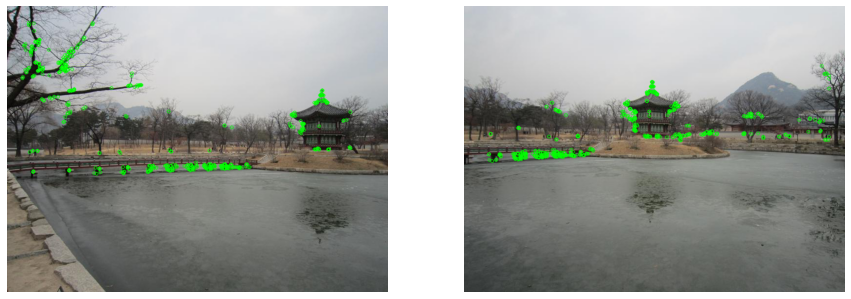

In [ ]:
kp_1, desc_1 = get_features(img1)
kp_2, desc_2 = get_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0,255,0), flags=0)

print('keypoints for img1 and img2')
plot_imgs(kp_img1, kp_img2)

feature matches


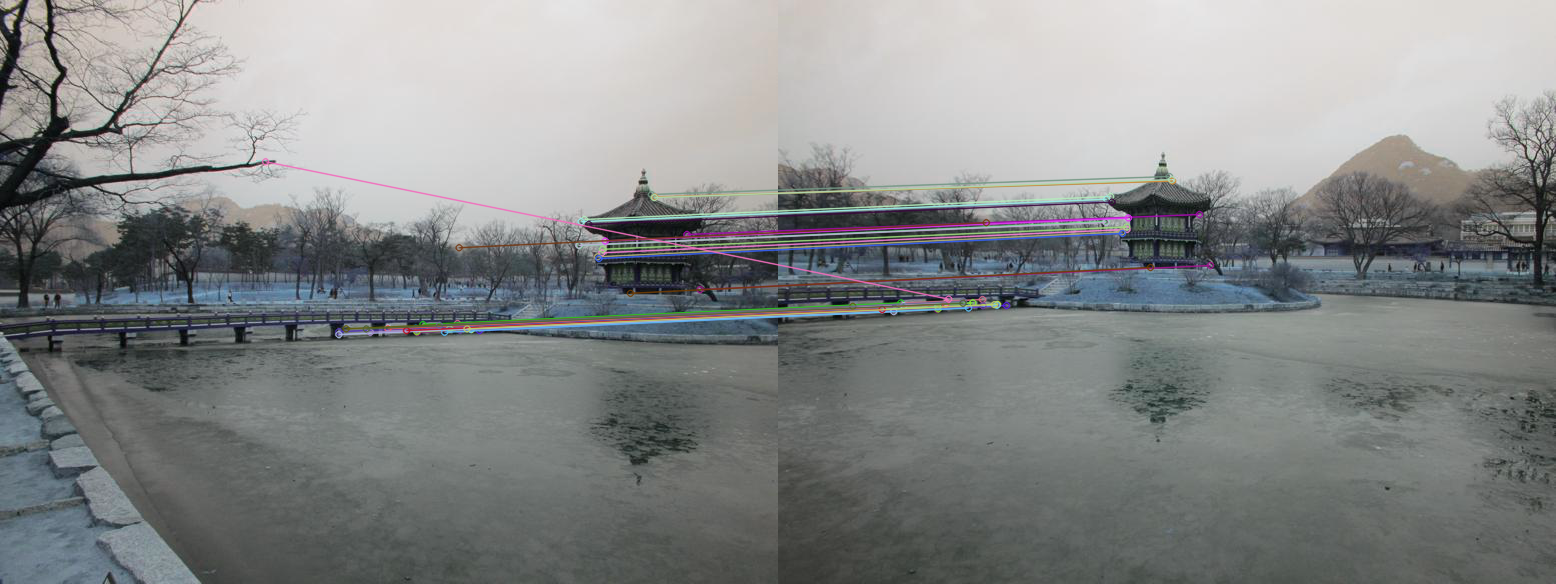

In [ ]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:], None, flags=2)
print("feature matches")
cv2_imshow(match_plot)

# Compute Homography Matrix using RANSAC

In [ ]:
def find_homography(pts_1, pts_2):
  '''
    Implement Direct Linear Transform to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Input:
      pts_1, pts_1: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
  '''
  # ===============================================
  # TODO
  # ===============================================
  # Here I am taking pts_2 = H * pts_1 so pts_2 points are x' and pts_1 points are x
  assert pts_1.shape[0] == pts_2.shape[0] #length of the two arrays should be the same
  N = pts_1.shape[0]
  #creating matrix A
  A = np.zeros([1,9])
  for k in range(N):
    x,y = pts_1[k]
    x_1,y_1 = pts_2[k]
    l1 = np.array([[-x,-y,-1,0,0,0,x*x_1,y*x_1,x_1]])
    l2 = np.array([[0,0,0,-x,-y,-1,x*y_1,y*y_1,y_1]])
    A = np.concatenate([A,l1,l2],axis = 0)
  #removing the first row
  #print("the shape of A is ")
  A = A[1:,:]
  #print(A.shape)
  #u,Sig ,v =svd(A) #note here v is v.T it should be transposed
  #v = v.T
  #ind = Sig.shape[0] -1
  #print("the shape of u is ")
  #print(u.shape)
  #print("the shape of v is ")
  #print(v.shape)
  #print("the shape of Sig is ")
  #print(Sig.shape)
  #print("the value of v is :")
  #print(v)
  #print("the value of SIg is :")
  #print(Sig)
  #print("the value of u is :")sufficient
  #print(u)
  #print(ind)
  ##column vector corresponding to the
  #H = v[:,ind]
  #H = H.reshape(3,3) 
  net = A.T @ A
  w,v = eig(net)
  # w is eigen values
  # v is eigen vectors
  #print("the eigen values are:")
  #print(w)
  w[w < 5e-3] = 0
  #print("the trimmed eigen values are")
  #print(w)
  min_eig_ind = np.argmin(w)
  #print("the index of the min eigen value is ")
  #print(min_eig_ind)
  #print("the eigen vectors are")
  #print(v)
  H = v[:,min_eig_ind]
  H = H/(H[-1])
  #print("the required eigen vector is")
  #print(H)
  H = H.reshape(3,3)
  return H

In [ ]:
def mse_dist(pt_1,pt_2,H):
  '''
    This function is for finding distance between the point predicted in homography and the actual point
    input:
      pt_1 : point in the image plane on which homography is applies shape = (1,2)
      pt_2 : expected point in the new image plane after homography transformation shape = (1,2)
      H    : Homography transformation
    output
      The distance between the required points mentioned above  
  '''
  pt_1h = np.concatenate((pt_1,np.array([1])),axis = 0)
  pt_2eh = H @ pt_1h
  pt_2e = (pt_2eh[0]/pt_2eh[2],pt_2eh[1]/pt_2eh[2])
  dist = np.sum((pt_2e - pt_2)**2)
  return dist

In [ ]:
def transform_ransac(pts_1, pts_2, M = 5):
  '''
    Implement RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
      M = margin of ransac
    Return:
      best_model: homography matrix with most inliers
  '''
  # ===============================================
  # TODO
  # ===============================================
  #total number of matches
  assert pts_1.shape[0] == pts_2.shape[0] #length of the two arrays should be the same
  N = pts_1.shape[0]
  #store the best value of H
  best_H = np.zeros([3,3])
  #find the number of inliers for that best value of H
  best_no_inliers = 0
  #implementing ransac
  no_loops = 100 #no of loops to remove outliers
  rng = np.random.default_rng()
  for _ in range(no_loops):
    #randomly choose 4 indices
    indices = rng.choice(N,6,replace= False)
    pts_1in = pts_1[indices]
    pts_2in = pts_2[indices]
    H = find_homography(pts_1=pts_1in,pts_2= pts_2in)
    no_inliers = 0
    for k in range(N):
      if k not in indices:
        dst = mse_dist(pt_1 = pts_1[k] ,pt_2 = pts_2[k],H = H)
        #print(dst)
        if (M > dst):
          no_inliers = no_inliers + 1
    #print(no_inliers) 
    if (no_inliers > best_no_inliers):
      best_H = H
      best_no_inliers = no_inliers
    best_model = best_H
  #plotting the correspondence
  #find the inliers
  inliers = []
  outliers = []
  for k in range(N):
    dst = mse_dist(pt_1 = pts_1[k] ,pt_2 = pts_2[k],H = best_H)
    if (M > dst):
      inliers.append(k)
    else:
      outliers.append(k)
  best_no_inliers = len(inliers)
  return best_model,best_no_inliers,inliers,outliers


In [ ]:
def inlier_v_outliers(img1,img2,inliers,outliers,pts_1,pts_2):
  plt.figure(figsize=(12,12))
  plt.subplot(1,2,1)
  plt.imshow(img1)
  plt.scatter(pts_1[inliers][:,0],pts_1[inliers][:,1],c = 'g',label = 'inlier')
  plt.scatter(pts_1[outliers][:,0],pts_1[outliers][:,1],c = 'r',label = 'outlier')
  plt.axis('off')
  plt.subplot(1,2,2)
  plt.imshow(img2)
  plt.scatter(pts_2[inliers][:,0],pts_2[inliers][:,1],c = 'g',label = 'inlier')
  plt.scatter(pts_2[outliers][:,0],pts_2[outliers][:,1],c = 'r', label = 'outlier')
  plt.axis('off')
  plt.legend()
  plt.show()

# Panoramic Stitching

In [ ]:
def corss_pt(pt,H):
  '''
    This funciton converts pt which is in homography plane(target plane) to source plane 
    input:
      pt : point in destination homography plane
      H : homography
    output:
      pt in source plane 
  '''
  h1,h2,h3,h4,h5,h6,h7,h8,h9 = H.reshape(-1)
  x1,y1 = pt
  x = -1*((h3 - h9*x1)*(h5 - h8*y1) - (h2 - h8*x1)*(h6 - h9*y1))/((h1 - h7*x1)*(h5 - h8*y1)-(h2 - h8*x1)*(h4 - h7*y1))
  y = ((h3 - h9*x1)*(h4 - h7*y1) - (h1 - h7*x1)*(h6 - h9*y1))/((h1 - h7*x1)*(h5 - h8*y1)-(h2 - h8*x1)*(h4 - h7*y1))
  return np.array([x,y])


In [ ]:
def stich_img(img1,img2,H):
  """
    This function is for stiching the two img1 and img2 where H is homography transform between img1 and img2
    img2 = H img1
    inputs:
      images : img1, img2
      homography: H
    output:
    stiched image
  """
  #takin bottom left corner as the origin in both image plane perspective
  #p20,p21,p22,p23 are the points on img2 corners in anti clockwise order in img2 plane
  p20 = np.array([0,0])
  p21 = np.array([img2.shape[1],0])
  p22 = np.array([img2.shape[1],img2.shape[0]])
  p23 = np.array([0,img2.shape[0]])
  #p0_1,p1_1,p2_1,p3_1 are the points of img2 corners in img1 geometric plane
  p0_1 = corss_pt(p20,H)
  p1_1 = corss_pt(p21,H)
  p2_1 = corss_pt(p22,H)
  p3_1 = corss_pt(p23,H)
  #check images
  #ch0 = H @ np.concatenate([p0_1,np.array([1])],axis = 0) 
  #ch1 = H @ np.concatenate([p1_1,np.array([1])],axis = 0)
  #ch2 = H @ np.concatenate([p2_1,np.array([1])],axis = 0)
  #ch3 = H @ np.concatenate([p3_1,np.array([1])],axis = 0)
  #print("check images")
  #print(ch0[0]/ch0[2],ch0[1]/ch0[2])
  #print(ch1[0]/ch1[2],ch1[1]/ch1[2])
  #print(ch2[0]/ch2[2],ch2[1]/ch2[2])
  #print(ch3[0]/ch3[2],ch3[1]/ch3[2])
  #p10,p11,p12,p13 are the points on img1 corners in anti clockwise order in img1 plane
  p10 =  np.array([0,0])
  p11 = np.array([img1.shape[1],0])
  p12 = np.array([img1.shape[1],img1.shape[0]])
  p13 = np.array([0,img1.shape[0]])
  #getting the dimensions of the stiched image and how much does img2 should be moved 
  dimx = img1.shape[1] + abs(min(0,p0_1[0] - p10[0]-1,p3_1[0] - p13[0]-1)) + max(0,p1_1[0] - p11[0],p2_1[0] - p12[0]) #x dimension of the stiched image
  dimy = img1.shape[0] + abs(min(0,p0_1[1] - p10[1]-1,p1_1[1] - p11[1]-1)) + max(0,p3_1[1] - p13[1],p2_1[1] - p12[1]) #y dimension of the stiched image
  shiftx = abs(min(0,p0_1[0] - p10[0]-1,p3_1[0] - p13[0]-1)) #how much the img1 should be shifted in x wrt stiched img
  shifty = abs(min(0,p0_1[1] - p10[1]-1,p1_1[1] - p11[1]-1)) #how much the img1 should be shifted in y wrt stiched img
  dimx = int(dimx)
  dimy = int(dimy)
  shiftx = int(shiftx)
  shifty = int(shifty)
  stch_img = np.zeros([dimy,dimx,3])
  stch_img1 = np.zeros([dimy,dimx,3])
  stch_img2 = np.zeros([dimy,dimx,3])
  #print(p0_1)
  #print(p1_1)
  #print(p2_1)
  #print(p3_1)
  #print(p10)
  #print(p11)
  #print(p12)
  #print(p13)
  #print("created an empty array of stich")
  #applying homography transform on the first image
  #x = np.array([0])
  #y = np.array([0])
  for y in range(stch_img.shape[0]):
    for x in range(stch_img.shape[1]):
      xp = x - shiftx
      yp = y - shifty
      p = np.array([xp,yp,1])
      ph = H @  p
      x_1 = ph[0]/ph[2]
      y_1 = ph[1]/ph[2]
      if((0 < x_1 < img2.shape[1]) and (0 < y_1 < img2.shape[0])):
        stch_img[y,x] = img2[int(y_1),int(x_1)]
  #applying a box filter on the ranges in which stich is applies
  #kernel = np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]])
  #print(kernel.shape)
  #stch_img[:,:,0] = griddata(x,y,stch_img[:,:,0],(x,y),method = 'cubic')
  #stch_img[:,:,1] = griddata(x,y,stch_img[:,:,1],(x,y),method = 'cubic')
  #stch_img[:,:,2] = griddata(x,y,stch_img[:,:,2],(x,y),method = 'cubic')
  stch_img[shifty:shifty+img1.shape[0],shiftx:shiftx+img1.shape[1]] = img1
  #return the output
  #print(type(stch_img)) 
  return stch_img

In [ ]:
def panoramic_stitching(img1, img2):
  '''
    Generate a panoramic image using the obtained homography matrix.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
  '''
  # ===============================================
  # TODO
  # ===============================================
  #finding the key points and descriptors for the two image
  kpt_1, desc_1 = get_features(img1)
  kpt_2, desc_2 = get_features(img2)
  #finding the matches in the keypoints in the two image
  matches = match_keypoints(desc_1 = desc_1, desc_2 = desc_2,ratio = 0.8)
  #giving the matches as the input to ransac
  #creating pts_1,pts_2
  pts_1 = np.zeros([1,2])
  pts_2 = np.zeros([1,2])
  for k in range(len(matches)):
    #print(np.array(kpt_1[matches[k].queryIdx].pt).shape)
    #print(pts_1.shape)
    pts_1 = np.concatenate([pts_1,np.array(kpt_1[matches[k].queryIdx].pt).reshape(1,2)],axis = 0)
    pts_2 = np.concatenate([pts_2,np.array(kpt_2[matches[k].trainIdx].pt).reshape(1,2)],axis = 0)
  pts_1 = pts_1[1:,:]
  pts_2 = pts_2[1:,:]
  #finding the homography
  H,no_inliers, inliers, outliers = transform_ransac(pts_1= pts_1,pts_2 = pts_2,M = 5)
  print("image showing the inliers and outliers on both images")
  inlier_v_outliers(img1,img2,inliers,outliers,pts_1,pts_2)
  print("the number of inliers = {} out of {} matches".format(no_inliers,len(matches)))
  out = stich_img(img1,img2,H)
  #out1,out2 = stich_img(img2,img1,H)
  return out

image showing the inliers and outliers on both images


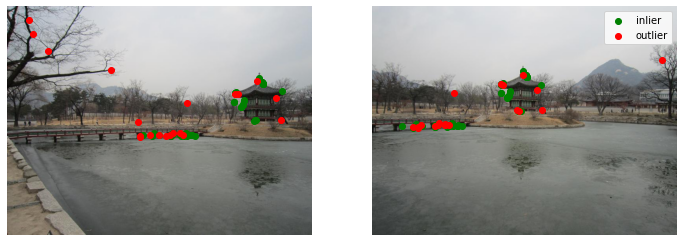

the number of inliers = 43 out of 63 matches


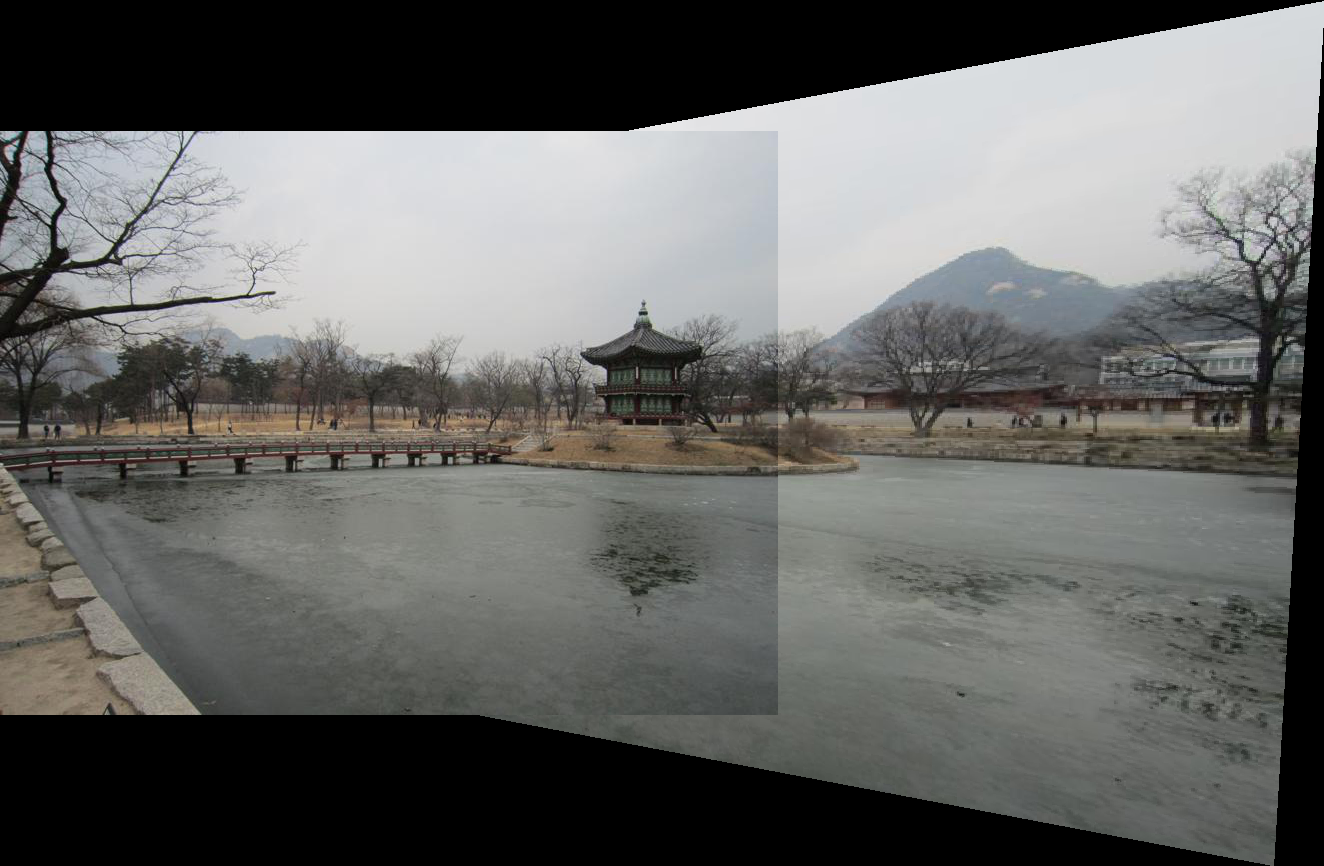

In [ ]:
result = panoramic_stitching(img1, img2)
cv2_imshow(result[:,:,::-1])

# Panaroma stiching for 3 image


In [ ]:
%%capture
! wget -O img31.jpg "https://drive.google.com/uc?export=download&id=1ShFpejaR3iunYoKkCFhBmliq9vJDr6KQ"
! wget -O img32.jpg "https://drive.google.com/uc?export=download&id=1t5ReG_BtaWY7PsLwExuMwSRBoHumotiH"
! wget -O img33.jpg "https://drive.google.com/uc?export=download&id=19r7oo2vJ-1Vr62ru3Wu1jiwer49GV_FK"

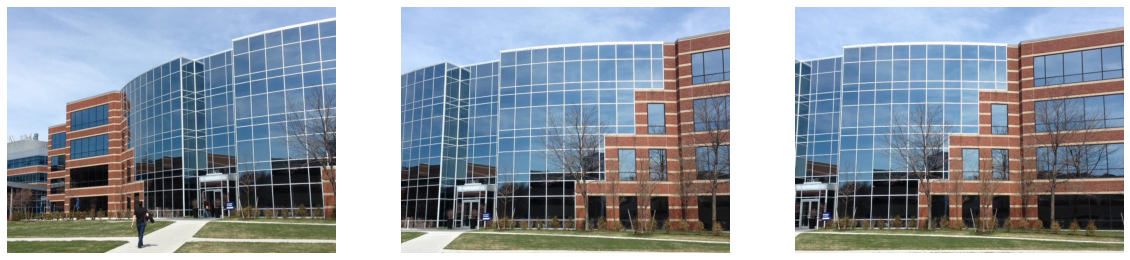

In [ ]:
img31 = plt.imread("img31.jpg")
img32 = plt.imread("img32.jpg")
img33 = plt.imread("img33.jpg")
plt.figure(figsize= (20,30))
plt.subplot(1,3,1)
plt.imshow(img31)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img32)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img33)
plt.axis('off')
plt.show()

In [ ]:
def stich3_img(img1,img2,img3,H12,H13):
  """
    This funciton is for stitching three images img1 is the base image over which all images are added over
    H12,H13 are the homographies of img2 and img3 wrt img1
    input:
      img1 : base main image 
      img2,img3: other input images
      H12,H13 : corresponding homography matrix
    output :
      outstich : image
  """
  #takin bottom left corner as the origin in both image plane perspective
  #p20,p21,p22,p23 are the points on img2 corners in anti clockwise order in img2 plane
  p20 = np.array([0,0])
  p21 = np.array([img2.shape[1],0])
  p22 = np.array([img2.shape[1],img2.shape[0]])
  p23 = np.array([0,img2.shape[0]])
  #p0_1,p1_1,p2_1,p3_1 are the points of img2 corners in img1 geometric plane
  p20_1 = corss_pt(p20,H12)
  p21_1 = corss_pt(p21,H12)
  p22_1 = corss_pt(p22,H12)
  p23_1 = corss_pt(p23,H12)

  #p30,p31,p32,p33 are the points on img3 corners in anti clockwise order in img3 plane
  p30 = np.array([0,0])
  p31 = np.array([img3.shape[1],0])
  p32 = np.array([img3.shape[1],img3.shape[0]])
  p33 = np.array([0,img3.shape[0]])
  #p0_1,p1_1,p2_1,p3_1 are the points of img3 corners in img1 geometric plane
  p30_1 = corss_pt(p30,H13)
  p31_1 = corss_pt(p31,H13)
  p32_1 = corss_pt(p32,H13)
  p33_1 = corss_pt(p33,H13)
  
  #print("check images")
  #print(ch0[0]/ch0[2],ch0[1]/ch0[2])
  #print(ch1[0]/ch1[2],ch1[1]/ch1[2])
  #print(ch2[0]/ch2[2],ch2[1]/ch2[2])
  #print(ch3[0]/ch3[2],ch3[1]/ch3[2])
  #p10,p11,p12,p13 are the points on img1 corners in anti clockwise order in img1 plane
  p10 =  np.array([0,0])
  p11 = np.array([img1.shape[1],0])
  p12 = np.array([img1.shape[1],img1.shape[0]])
  p13 = np.array([0,img1.shape[0]])
  #getting the dimensions of the stiched image and how much does img2 should be moved 
  dimx = img1.shape[1] + abs(min(0,p20_1[0] - p10[0]-1,p23_1[0] - p13[0]-1,p30_1[0] - p10[0]-1,p33_1[0] - p13[0]-1)) + max(0,p21_1[0] - p11[0],p22_1[0] - p12[0],p31_1[0] - p11[0],p32_1[0] - p12[0]) #x dimension of the stiched image
  dimy = img1.shape[0] + abs(min(0,p20_1[1] - p10[1]-1,p21_1[1] - p11[1]-1,p30_1[1] - p10[1]-1,p31_1[1] - p11[1]-1)) + max(0,p23_1[1] - p13[1],p22_1[1] - p12[1],p33_1[1] - p13[1],p32_1[1] - p12[1]) #y dimension of the stiched image
  shiftx = abs(min(0,p20_1[0] - p10[0]-1,p23_1[0] - p13[0]-1,p30_1[0] - p10[0]-1,p33_1[0] - p13[0]-1)) #how much the img1 should be shifted in x wrt stiched img
  shifty = abs(min(0,p20_1[1] - p10[1]-1,p21_1[1] - p11[1]-1,p30_1[1] - p10[1]-1,p31_1[1] - p11[1]-1)) #how much the img1 should be shifted in y wrt stiched img
  dimx = int(dimx)
  dimy = int(dimy)
  shiftx = int(shiftx)
  shifty = int(shifty)
  stch_img = np.zeros([dimy,dimx,3])
  
  #print(p0_1)
  #print(p1_1)
  #print(p2_1)
  #print(p3_1)
  #print(p10)
  #print(p11)
  #print(p12)
  #print(p13)
  #print("created an empty array of stich")
  #applying homography transform on the first image
  #x = np.array([0])
  #y = np.array([0])
  for y in range(stch_img.shape[0]):
    for x in range(stch_img.shape[1]):
      xp = x - shiftx
      yp = y - shifty
      p = np.array([xp,yp,1])
      ph = H12 @  p
      x_1 = ph[0]/ph[2]
      y_1 = ph[1]/ph[2]
      if ((0 < x_1 < img2.shape[1]) and (0 < y_1 < img2.shape[0])):
        stch_img[y,x] = img2[int(y_1),int(x_1)]
  for y in range(stch_img.shape[0]):
    for x in range(stch_img.shape[1]):
      xp = x - shiftx
      yp = y - shifty
      p = np.array([xp,yp,1])
      ph = H13 @  p
      x_1 = ph[0]/ph[2]
      y_1 = ph[1]/ph[2]
      if ((0 < x_1 < img3.shape[1]) and (0 < y_1 < img3.shape[0])):
        stch_img[y,x] = img3[int(y_1),int(x_1)]
  #applying a box filter on the ranges in which stich is applies
  #kernel = np.array([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]])
  #print(kernel.shape)
  #stch_img[:,:,0] = griddata(x,y,stch_img[:,:,0],(x,y),method = 'cubic')
  #stch_img[:,:,1] = griddata(x,y,stch_img[:,:,1],(x,y),method = 'cubic')
  #stch_img[:,:,2] = griddata(x,y,stch_img[:,:,2],(x,y),method = 'cubic')
  stch_img[shifty:shifty+img1.shape[0],shiftx:shiftx+img1.shape[1]] = img1
  #return the output
  #print(type(stch_img)) 
  return stch_img

In [ ]:
def pan3oma(img1,img2,img3):
  #finding the key points and descriptors for the two image
  kpt_1, desc_1 = get_features(img1)
  kpt_2, desc_2 = get_features(img2)
  kpt_3, desc_3 = get_features(img3)
  #finding the matches in the keypoints in the two image
  matches12 = match_keypoints(desc_1 = desc_1, desc_2 = desc_2,ratio = 0.8)
  matches13 = match_keypoints(desc_1 = desc_1, desc_2 = desc_3,ratio = 0.8)
  #giving the matches as the input to ransac
  #creating pts_1,pts_2
  pts_12 = np.zeros([1,2])
  pts_13 = np.zeros([1,2])
  pts_2 = np.zeros([1,2])
  pts_3 = np.zeros([1,2])
  for k in range(len(matches12)):
    #print(np.array(kpt_1[matches[k].queryIdx].pt).shape)
    #print(pts_1.shape)
    pts_12 = np.concatenate([pts_12,np.array(kpt_1[matches12[k].queryIdx].pt).reshape(1,2)],axis = 0)
    #pts_13 = np.concatenate([pts_13,np.array(kpt_1[matches13[k].queryIdx].pt).reshape(1,2)],axis = 0)
    pts_2 = np.concatenate([pts_2,np.array(kpt_2[matches12[k].trainIdx].pt).reshape(1,2)],axis = 0)
    #pts_3 = np.concatenate([pts_3,np.array(kpt_3[matches13[k].queryIdx].pt).reshape(1,2)],axis = 0)
  for k in range(len(matches13)):
    #print(np.array(kpt_1[matches[k].queryIdx].pt).shape)
    #print(pts_1.shape)
    #pts_12 = np.concatenate([pts_12,np.array(kpt_1[matches12[k].queryIdx].pt).reshape(1,2)],axis = 0)
    pts_13 = np.concatenate([pts_13,np.array(kpt_1[matches13[k].queryIdx].pt).reshape(1,2)],axis = 0)
    #pts_2 = np.concatenate([pts_2,np.array(kpt_2[matches12[k].trainIdx].pt).reshape(1,2)],axis = 0)
    pts_3 = np.concatenate([pts_3,np.array(kpt_3[matches13[k].trainIdx].pt).reshape(1,2)],axis = 0)
  pts_12 = pts_12[1:,:]
  pts_13 = pts_13[1:,:]
  pts_2 = pts_2[1:,:]
  pts_3 = pts_3[1:,:]
  #finding the homography
  H12,no_inliers12, inliers12, outliers12 = transform_ransac(pts_1= pts_12,pts_2 = pts_2,M = 5)
  H13,no_inliers13, inliers13, outliers13 = transform_ransac(pts_1= pts_13,pts_2 = pts_3,M = 5)
  print("image showing the inliers and outliers on images 1 and 2")
  inlier_v_outliers(img1,img2,inliers12,outliers12,pts_12,pts_2)
  print("the number of inliers = {} out of {} matches".format(no_inliers12,len(matches12)))
  print("image showing the inliers and outliers on images 1 and 3")
  inlier_v_outliers(img1,img3,inliers13,outliers13,pts_13,pts_3)
  print("the number of inliers = {} out of {} matches".format(no_inliers13,len(matches13)))
  out = stich3_img(img1,img2,img3,H12,H13)
  return out

image showing the inliers and outliers on images 1 and 2


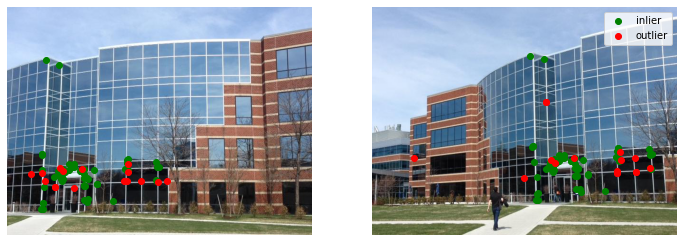

the number of inliers = 59 out of 75 matches
image showing the inliers and outliers on images 1 and 3


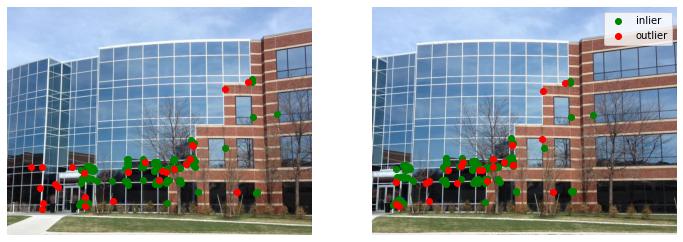

the number of inliers = 110 out of 135 matches


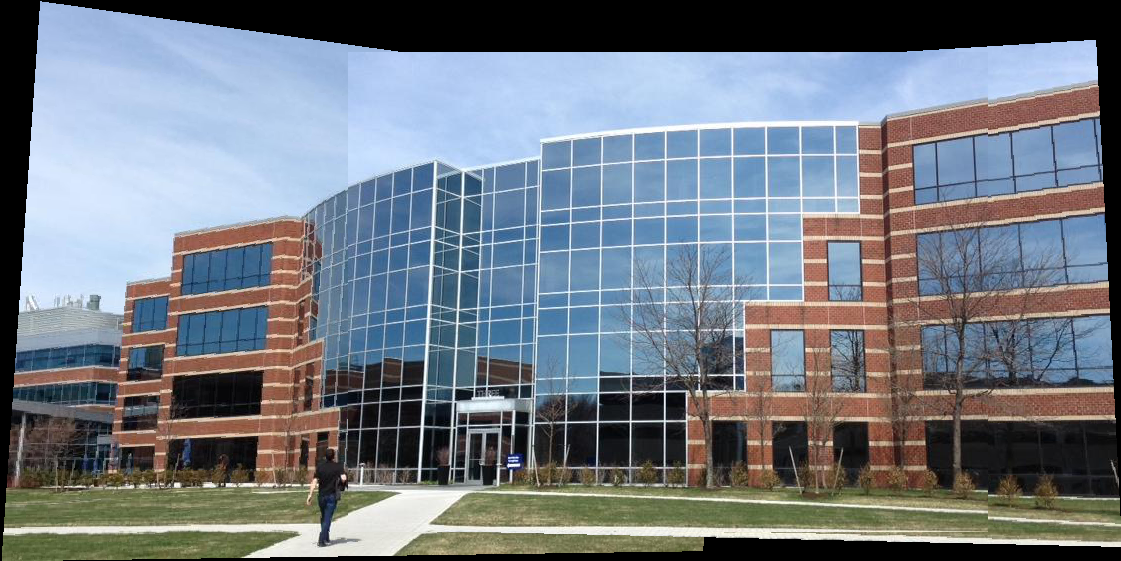

In [ ]:
result = pan3oma(img32, img31,img33)
cv2_imshow(result[:,:,::-1])